<a href="https://colab.research.google.com/github/tobwalker/Course_Knowledge_Extraction_and_Information_Retrieval/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Packages
!pip install keras-tuner

import glob, json, nltk, os, pickle, random, re, requests, string, torch, zipfile, itertools
from collections import Counter, defaultdict, OrderedDict
from typing import Any, Dict, List, Optional, Tuple, Union

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from tqdm import tqdm
from tqdm.notebook import tqdm

nltk.download("punkt")

from sklearn.metrics import confusion_matrix
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Attention, Bidirectional, Concatenate, Dense, Dropout, Embedding, GRU, Input, Layer, LayerNormalization, LSTM, TimeDistributed
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from kerastuner.engine.hyperparameters import HyperParameters


import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-1-919173ced73f>:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Import git repository
!git clone https://github.com/tobwalker/Course_Knowledge_Extraction_and_Information_Retrieval.git

Cloning into 'Course_Knowledge_Extraction_and_Information_Retrieval'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 15 (delta 0), reused 6 (delta 0), pack-reused 8
Receiving objects: 100% (15/15), 77.09 MiB | 21.37 MiB/s, done.


### 1. Dataset of Correct Sentences

In [ ]:
# ***** Import the dataset ***** ##
os.environ['KAGGLE_USERNAME'] = "tobiaswalker"
os.environ['KAGGLE_KEY'] = "88850f61e69e9caf50b5d36ff9401259"
# Download and extract dataset from Kaggle
!kaggle datasets download -d mikeortman/wikipedia-sentences
zip_path = "/content/wikipedia-sentences.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
  file_list = [name for name in zip_ref.namelist()]
  zip_ref.extractall(path=extract_path, members=file_list)
# Import text file
f = open("/content/wikisent2.txt", "r")
text = f.read()
# Split sentences by new line character
dataset = text.split(sep="\n")
# Remove duplicate sentences
dataset = list(set(dataset))
# Print number of sentences obtained and an example sentences
print(f"\nTotal number of sentences: {len(dataset)}")
# Only keep 100_000 sentences
dataset = random.sample(dataset, 100_000)
print(f"Total number of sentences after sampling: {len(dataset)}")
print(f"Example sentence: {dataset[0]}")

 98% 306M/314M [00:02<00:00, 153MB/s]
100% 314M/314M [00:02<00:00, 123MB/s]

Total number of sentences: 7871826
Total number of sentences after sampling: 100000
Example sentence: Best known for their quirky approach to songwriting, Sparks' music is often accompanied by cutting and acerbic lyrics, and an idiosyncratic stage presence, typified in the contrast between Russell's wide-eyed hyperactive frontman antics and Ron's sedentary scowling.


### 2. Class that sets up the pre-processing of the data

Pre-processing procedure:

1.   Takes a list of correct sentences (from Wikipedia) and turns all characters lowercase, removes leading or trailing whitespaces and replaces/removes certain special characters
2.   Removes all sentences that are longer than 200 characters
3.   Maps the characters in a tokenizer
4.   Splits the list of sentences into a train and test set
5.   Tokenizes and pads the correct sentences
6.   Creates erroneous sentences by randomly swapping tokens



In [3]:
class DatasetPreparation:
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
    ) -> None:
        """
        Initializes the DatasetPreparation object. If a list of sentences is parsed, then the list is processed.

        Args:
          sentences: List of input sentences
          max_length_of_sentence: Maximum length of any allowed sentence
          share_train: Proportion of data to be used for training
          probability_char_swap: Probability to swap a token when creating erroneous sentences
        """
        self.max_length_of_sentence = max_length_of_sentence
        self.probability_char_swap = probability_char_swap
        self.share_train = share_train
        if sentences:
            self.prepare_dataset(sentences)


    def prepare_dataset(self, sentences: List[str],) -> None:

        """
        Preprocesses the input sentences, prepares them for the ML model by tokenizing and padding them, and then creates
        the erroneous sentences by randomly swapping tokens
        """

        # Preprocess the correct sentences
        correct_sentences = [formatted_sentence for formatted_sentence in
                            (self.format_a_sentence(sentence, raise_error=False) for sentence in sentences)
                            if formatted_sentence is not None]
        print(f"Number of sentences after formating: {len(correct_sentences)}")
        # Create tokenizer out of processed correct sentences
        self._map_chars(correct_sentences)
        # Split correct sentences into train and test set
        correct_train, correct_test = self._split_list_of_sentences(correct_sentences)
        print(f"Training set: {len(correct_train)}")
        print(f"Test set: {len(correct_test)}")
        # Tokenize and pad correct sentences
        self.correct_train = self.tokenize_and_pad_list_of_sentences(correct_train)
        self.correct_test = self.tokenize_and_pad_list_of_sentences(correct_test)
        # Create erroneous sets
        self.erroneous_train = self.introduce_random_errors_in_tok_padded_sentences(self.correct_train)
        self.erroneous_test = self.introduce_random_errors_in_tok_padded_sentences(self.correct_test)


    def format_a_sentence(self, sentence: str, raise_error: bool,) -> Optional[str]:

        """
        Returns filtered and formatted sentence, or None if max length is exceeded
        """

        # Remove non valid characters
        valid_characters = "[^a-zA-Z0-9 \!\?,\.:;\"%&'\-]"
        sentence = re.sub(valid_characters, "", sentence)
        # Lowercase, remove trailing/leading whitespaces, replace ‘ and ’ with '
        sentence = sentence.lower().strip().replace("‘", "'").replace("’", "'")
        # Remove too long sentences
        if len(sentence) <= self.max_length_of_sentence:
            return sentence
        elif raise_error:
            raise ValueError(f"Sentence exceeds allowed length of {self.max_length_of_sentence} characters")


    def _map_chars(self, sentences: List[str]) -> None:

        """
        Builds a tokenizer from the a list of sentences.
        """

        self.tokenizer = Tokenizer(char_level=True, filters="", oov_token="<oov>", lower=True)
        self.tokenizer.fit_on_texts(sentences)
        self.tokenizer.word_index["<pad>"] = 0
        self.tokenizer.index_word[0] = "<pad>"


    def _split_list_of_sentences(self, sentences: List[str],) -> Tuple[List[str], List[str]]:

        """
        Splits a list of sentences into 2 sets (train and test set)
        """

        random.shuffle(sentences)
        length_train = int(self.share_train * len(sentences))
        train = sentences[: length_train]
        test = sentences[length_train :]
        return train, test


    def tokenize_and_pad_list_of_sentences(self, sentences: List[str],) -> np.ndarray:

        """
        Tokenizes and pads a list of sentences.
        """

        tokenized_sentences = self.tokenizer.texts_to_sequences(sentences)
        return pad_sequences(tokenized_sentences, padding="post", maxlen=self.max_length_of_sentence)


    def introduce_random_errors_in_tok_padded_sentences(self, sentences: np.ndarray,) -> np.ndarray:

        """
        Introduces artificial errors into a list of sentences by randomly replacing charcters with random ASCII lowercase
        characters. Works on the tokenized and padded sentences.
        """

        erroneous_sen = np.copy(sentences)
        for i in range(sentences.shape[0]):
          for j in range(sentences.shape[1]):
            if (random.random() <= self.probability_char_swap) & (sentences[i,j] != 0):
              erroneous_sen[i, j] = self.tokenizer.texts_to_sequences(random.choice(string.ascii_lowercase))[0][0]
        return erroneous_sen


## 3. Error Detection Model

Models that detect spelling mistakes on a character level. In total 3 different LSTM models are tested. A baseline model, a more complex model and a model containing an attention layer.

In [4]:
class DataAugmentationDetection(Callback):

    """
    Callback for performing data augmentation (new errors) at the beginning of each epoch
    """

    def __init__(self, model_instance: Any) -> None:
        super(DataAugmentationDetection, self).__init__()
        self.model_instance = model_instance


    def on_epoch_begin(self, epoch: int, logs: Optional[Dict[str, Any]] = None) -> None:

        """
        Introduces new errors into  training data and updates the error mask (target)
        """

        self.model_instance.erroneous_train = self.model_instance.introduce_random_errors_in_tok_padded_sentences(
            self.model_instance.correct_train
        )
        self.model_instance.binary_errors_train = self.model_instance.error_mask(
            self.model_instance.correct_train, self.model_instance.erroneous_train
        )


In [5]:
class ErrorDetectionModel(DatasetPreparation):
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
    ) -> None:
        # Initialize the base class and any additional instance variables
        super().__init__(
            sentences = sentences,
            max_length_of_sentence = max_length_of_sentence,
            probability_char_swap = probability_char_swap,
            share_train = share_train
        )
        # Build binary error lists for training and test data if list of sentences is parsed
        if sentences:
          self.binary_errors_train = self.error_mask(self.correct_train, self.erroneous_train)
          self.binary_errors_test = self.error_mask(self.correct_test, self.erroneous_test)


    def error_mask(
        self, correct_sen: np.ndarray, erroneous_sen: np.ndarray,
    ) -> np.ndarray:

        """
        Builds the binary error mask based on the comparison between correct and erroneous sentences. Used as target.
        """

        error_mask = []
        for sentence_correct, sentence_error in zip(correct_sen, erroneous_sen):
            labels = [int(char_correct != char_error)
                      for char_correct, char_error in zip(sentence_correct, sentence_error)]
            error_mask.append(labels)
        return np.array(error_mask)


    def model_trainer(self, model: Union[Sequential, Model], epochs: int, batch_size: int, patience: int,) -> None:
        """
        Fits the model, including the data augmentation layer and an early stop condition on the validation accuracy
        """

        self.model = model
        # Callbacks: data augmentation and early stopping
        da_callback = DataAugmentationDetection(self)
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=patience)
        # Fit the model
        self.history = self.model.fit(
            self.erroneous_train,
            self.binary_errors_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.erroneous_test, self.binary_errors_test),
            callbacks=[early_stopping, da_callback]
        )
        # Evaluate the model on test data
        loss, accuracy, recall = self.model.evaluate(self.erroneous_test, self.binary_errors_test)
        print(f"\nLoss on the test set: {loss:.4f}")
        print(f"Accuracy on the test set: {accuracy:.4f}")
        print(f"Recall on the test set: {recall:.4f}\n")


    def plot_training_metrics(self, width: float, height: float) -> None:

        """
        Plot the development of loss, accuracy, and recall over the training process.
        """

        plt.figure(figsize=(width, height))
        metrics = ["loss", "accuracy", "recall"]

        for idx, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, idx)
            plt.plot(self.history.history[metric], label=f"Training {metric.capitalize()}")
            plt.plot(self.history.history[f"val_{metric}"], label=f"Validation {metric.capitalize()}")
            plt.title(metric.capitalize())
            plt.xlabel("Epoch")
            plt.ylabel(f"{metric.capitalize()} Value")
            plt.legend()

        plt.tight_layout()
        plt.show()


    def print_confusion_matrix(self):
        predictions = np.round(self.model.predict(self.erroneous_test)).astype(int)
        y_true = self.binary_errors_test.flatten()
        y_pred = predictions.flatten()
        cm = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = cm.ravel()
        fp_error = (FP / (FP + TN)) * 100 if FP + TP != 0 else 0
        fn_error = (FN / (FN + TP)) * 100 if FN + FP != 0 else 0
        print("Confusion Matrix:")
        print(cm)
        print("\nLayout:")
        print("[[TN, FP],")
        print(" [FN, TP]]")
        print("\nError Percentages:")
        print(f"False positive rate: {fp_error:.2f}%")
        print(f"False negative rate: {fn_error:.2f}%")


    def save_model_and_tokenizer(self, filepath_model: str, filepath_tokenizer: str,) -> None:

        """
        Save the trained model (.h5) and tokenizer (.json)
        """

        self.model.save(filepath_model)
        with open(filepath_tokenizer, "wb") as f:
            pickle.dump(self.tokenizer, f)


    def load_model_and_tokenizer(self, filepath_model: str, filepath_tokenizer: str) -> None:

        """
        Load a trained model and tokenizer and retrieve allowed sentence length from the 1st layer of the model
        """
        self.model = load_model(filepath_model)
        with open(filepath_tokenizer, "rb") as f:
            self.tokenizer = pickle.load(f)
        try:
            self.max_length_of_sentence = error_detection.model.layers[0].input_shape[0][1]
        except TypeError:
            self.max_length_of_sentence = error_detection.model.layers[0].input_shape[1]



    def apply_error_detection_to_a_sentence(self, sentence: str,  details: bool = False,) -> str:

        """
        Detect errors in a given sentence using the trained model.

        Args:
          sentence: The input sentence
          details: show prediction value for each character
        """

        sentence = self.format_a_sentence(sentence, raise_error=True)
        sentence_tok_and_padded = self.tokenize_and_pad_list_of_sentences([sentence])
        predictions = self.model.predict(sentence_tok_and_padded)
        # If 'details' is true, print the predicted probability for each character
        if details:
            predictions_list = predictions.tolist()
            chars = [char for char in sentence]
            for i in range(len(chars)):
                print(f'{chars[i]} - {round(predictions_list[0][i][0], 2)}')
        # Convert tokenized and padded sentence back to characters
        error_prediction = np.round(predictions[0]).astype(int)
        sentence_chars = [self.tokenizer.index_word.get(i, "") for i in sentence_tok_and_padded[0] if i != 0]
        error_chars = [s.upper() if e[0] else s for s, e in zip(sentence_chars, error_prediction)]
        result = "".join(error_chars)
        print(f"Input:  {sentence}")
        print(f"Output: {result}")
        return result


### Baseline Detection Model
Contains an embedding layer with dimnsion 64 and one bidirectional LSTM layer with 128 units (per direction), before giving it to a dense layer with 1 neuron and a sigmoid activation function to compute if error or not. The model is compiled with the 'ADAM' Optimizer.

In [ ]:
class BaselineErrorDetectionModel(ErrorDetectionModel):
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
    ) -> None:
        # Initialize the base class and any additional instance variables
        super().__init__(
            sentences = sentences,
            max_length_of_sentence = max_length_of_sentence,
            probability_char_swap = probability_char_swap,
            share_train = share_train
        )

    def baseline_model_builder(self, embedding_dim: int, lstm_units: int,) -> Sequential:

        """
        Sets up the baseline LSTM model and compiles it with ADAM as its optimizer.
        """

        vocab_size = len(self.tokenizer.word_index)
        sequence_length = self.max_length_of_sentence
        model = Sequential([
            Input(shape=(sequence_length,)),
            Embedding(vocab_size, embedding_dim),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            TimeDistributed(Dense(1, activation="sigmoid"))
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", Recall(name="recall")])
        return model


Number of sentences after formating: 91234
Training set: 72987
Test set: 18247


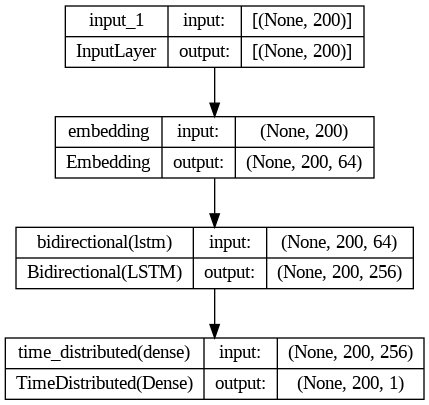

In [ ]:
error_detection = BaselineErrorDetectionModel(sentences=dataset, max_length_of_sentence=200, probability_char_swap=0.1, share_train=0.8)
baseline_model = error_detection.baseline_model_builder(embedding_dim=64, lstm_units=128)
plot_model(baseline_model, show_shapes=True)

In [ ]:
error_detection.model_trainer(model = baseline_model, epochs=20, batch_size=64, patience=3)
error_detection.save_model_and_tokenizer(filepath_model="detector_baseline_model.h5", filepath_tokenizer="detector_baseline_tokenizer.json")

Epoch 1/20
1141/1141 [==============================] - 45s 27ms/step - loss: 0.1311 - accuracy: 0.9568 - recall: 0.2068 - val_loss: 0.1090 - val_accuracy: 0.9616 - val_recall: 0.3454
Epoch 2/20
1141/1141 [==============================] - 29s 25ms/step - loss: 0.1002 - accuracy: 0.9647 - recall: 0.4008 - val_loss: 0.0944 - val_accuracy: 0.9669 - val_recall: 0.4619
Epoch 3/20
1141/1141 [==============================] - 25s 22ms/step - loss: 0.0892 - accuracy: 0.9687 - recall: 0.4905 - val_loss: 0.0859 - val_accuracy: 0.9698 - val_recall: 0.5032
Epoch 4/20
1141/1141 [==============================] - 25s 22ms/step - loss: 0.0816 - accuracy: 0.9714 - recall: 0.5472 - val_loss: 0.0798 - val_accuracy: 0.9720 - val_recall: 0.5580
Epoch 5/20
1141/1141 [==============================] - 27s 24ms/step - loss: 0.0765 - accuracy: 0.9731 - recall: 0.5822 - val_loss: 0.0761 - val_accuracy: 0.9731 - val_recall: 0.5709
Epoch 6/20
1141/1141 [==============================] - 29s 26ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


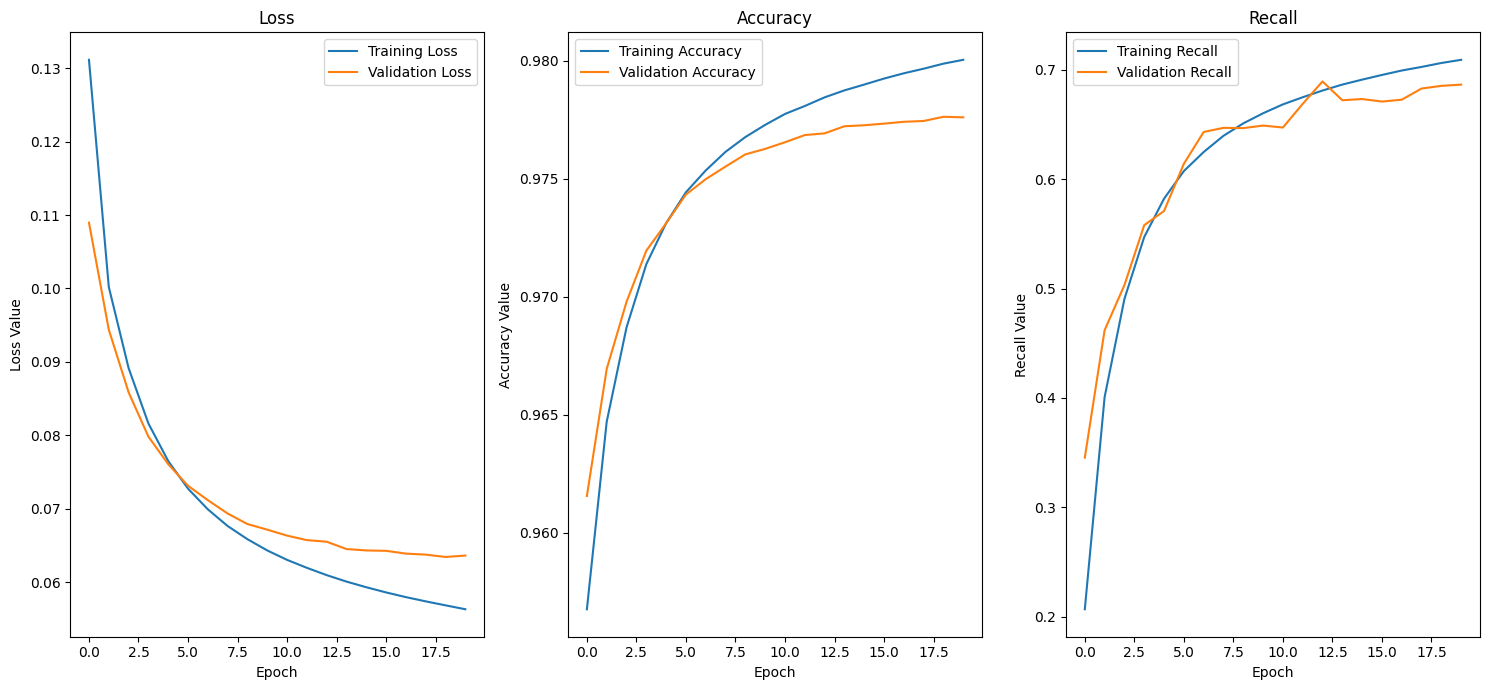

In [ ]:
error_detection.plot_training_metrics(width=15, height = 7)

In [ ]:
error_detection.print_confusion_matrix()

571/571 [==============================] - 5s 7ms/step
Confusion Matrix:
[[3440207   23509]
 [  58208  127476]]

Layout:
[[TN, FP],
 [FN, TP]]

Error Percentages:
False positive rate: 0.68%
False negative rate: 31.35%


In [ ]:
sentence = "tjis is a test senzence with wjich l wanp to test the midel."
_ = error_detection.apply_error_detection_to_a_sentence(sentence, details=True)
sentence = "The hyderparaneters of this model arc not tuted very well."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)
sentence = "He lifes in this verk nice neighburhood."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)

1/1 [==============================] - 0s 23ms/step
t - 0.02
j - 0.99
i - 0.11
s - 0.0
  - 0.0
i - 0.0
s - 0.0
  - 0.0
a - 0.0
  - 0.0
t - 0.14
e - 0.0
s - 0.02
t - 0.01
  - 0.0
s - 0.04
e - 0.0
n - 0.03
z - 0.87
e - 0.0
n - 0.01
c - 0.01
e - 0.01
  - 0.0
w - 0.0
i - 0.0
t - 0.0
h - 0.0
  - 0.0
w - 0.02
j - 1.0
i - 0.0
c - 0.0
h - 0.0
  - 0.0
l - 0.63
  - 0.0
w - 0.22
a - 0.0
n - 0.26
p - 0.68
  - 0.0
t - 0.0
o - 0.01
  - 0.0
t - 0.04
e - 0.01
s - 0.05
t - 0.0
  - 0.0
t - 0.0
h - 0.0
e - 0.0
  - 0.0
m - 0.17
i - 0.01
d - 0.0
e - 0.0
l - 0.13
. - 0.0
Input:  tjis is a test senzence with wjich l wanp to test the midel.
Output: tJis is a test senZence with wJich L wanP to test the midel.
1/1 [==============================] - 0s 22ms/step
Input:  the hyderparaneters of this model arc not tuted very well.
Output: the hyderparaneters of this model arC not tuted very well.
1/1 [==============================] - 0s 22ms/step
Input:  he lifes in this verk nice neighburhood.
Output: he lifes in

### More Complex LSTM Model
Contains an embedding layer with 128 dimensions, 2 bidirectional LSTM layers with each 256 units (per direction) and a dense layer with 128 neurons and a ReLU activation function, before ending in a dense layer with 1 neuron and a sigmoid activation function. It also adds a dropout rate of 0.1 behind the LSTM layers and the first dense layer.
The model is compiled with the 'ADAM' optimizer.

In [ ]:
class MoreComplexErrorDetectionModel(ErrorDetectionModel):
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
    ) -> None:
        # Initialize the base class and any additional instance variables
        super().__init__(
            sentences = sentences,
            max_length_of_sentence = max_length_of_sentence,
            probability_char_swap = probability_char_swap,
            share_train = share_train
        )


    def more_complex_model_builder(
        self, embedding_dim: int, lstm_units: int, dense_neurons: int, dropout_rate: float
    ) -> Sequential:

        """
        Sets up the baseline LSTM model and compiles it with ADAM as its optimizer.
        """

        vocab_size = len(self.tokenizer.word_index)
        sequence_length = self.max_length_of_sentence
        model = Sequential([
            Input(shape=(sequence_length,)),
            Embedding(vocab_size, embedding_dim),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            Dropout(dropout_rate),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            Dropout(dropout_rate),
            TimeDistributed(Dense(dense_neurons, activation="relu")),
            Dropout(dropout_rate),
            TimeDistributed(Dense(1, activation="sigmoid"))
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", Recall(name="recall")])
        return model


Number of sentences after formating: 91234
Training set: 72987
Test set: 18247


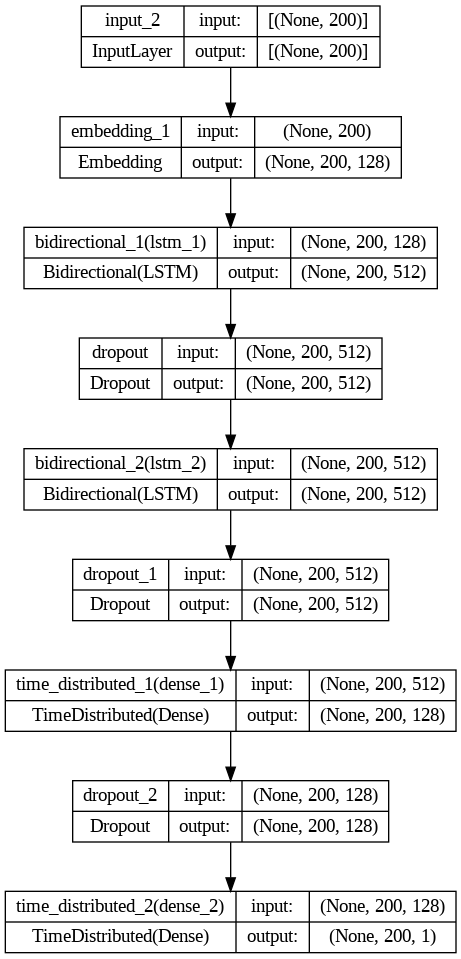

In [ ]:
error_detection = MoreComplexErrorDetectionModel(
    sentences=dataset, max_length_of_sentence=200, probability_char_swap=0.1, share_train=0.8
)
more_complex_model = error_detection.more_complex_model_builder(
    embedding_dim=128, lstm_units=256, dense_neurons=128, dropout_rate=0.1
)
plot_model(more_complex_model, show_shapes=True)

In [ ]:
error_detection.model_trainer(model=more_complex_model, epochs=20, batch_size=64, patience=3)
error_detection.save_model_and_tokenizer(filepath_model="detector_more_complex_model.h5", filepath_tokenizer="detector_more_complex_tokenizer.json")

Epoch 1/20
1141/1141 [==============================] - 135s 111ms/step - loss: 0.1137 - accuracy: 0.9615 - recall: 0.3364 - val_loss: 0.0894 - val_accuracy: 0.9688 - val_recall: 0.5000
Epoch 2/20
1141/1141 [==============================] - 116s 102ms/step - loss: 0.0797 - accuracy: 0.9723 - recall: 0.5666 - val_loss: 0.0698 - val_accuracy: 0.9755 - val_recall: 0.6387
Epoch 3/20
1141/1141 [==============================] - 115s 101ms/step - loss: 0.0646 - accuracy: 0.9774 - recall: 0.6567 - val_loss: 0.0593 - val_accuracy: 0.9791 - val_recall: 0.6698
Epoch 4/20
1141/1141 [==============================] - 112s 98ms/step - loss: 0.0551 - accuracy: 0.9806 - recall: 0.7093 - val_loss: 0.0528 - val_accuracy: 0.9812 - val_recall: 0.7255
Epoch 5/20
1141/1141 [==============================] - 112s 98ms/step - loss: 0.0486 - accuracy: 0.9828 - recall: 0.7445 - val_loss: 0.0493 - val_accuracy: 0.9824 - val_recall: 0.7465
Epoch 6/20
1141/1141 [==============================] - 112s 98ms/step -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


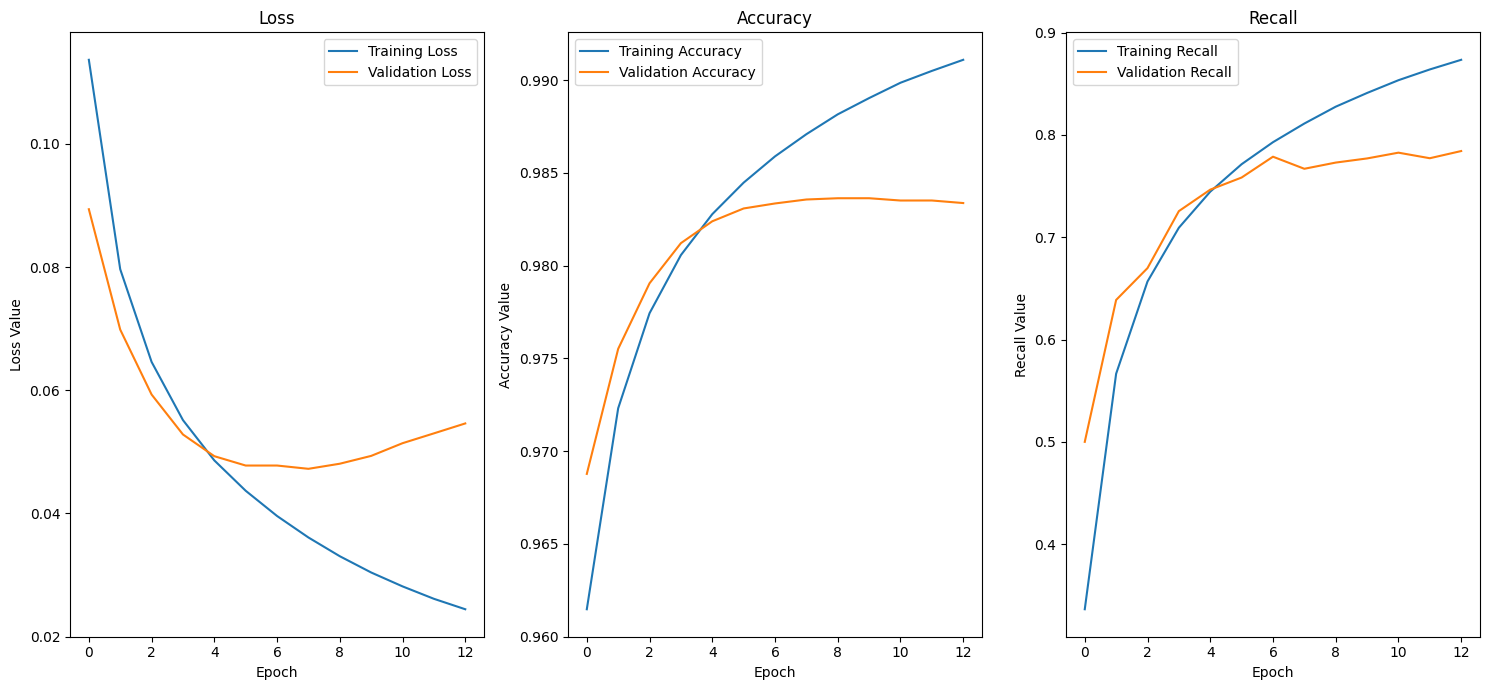

In [ ]:
error_detection.plot_training_metrics(width=15, height = 7)

In [ ]:
error_detection.print_confusion_matrix()

571/571 [==============================] - 13s 21ms/step
Confusion Matrix:
[[3443416   20670]
 [  39988  145326]]

Layout:
[[TN, FP],
 [FN, TP]]

Error Percentages:
False positive rate: 0.60%
False negative rate: 21.58%


In [ ]:
sentence = "tjis is a test senzence with wjich l wanp to test the midel."
_ = error_detection.apply_error_detection_to_a_sentence(sentence, details=True)
sentence = "The hyderparaneters of this model arc not tuted very well."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)
sentence = "He lifes in this verk nice neighburhood."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)

1/1 [==============================] - 0s 27ms/step
t - 0.0
j - 1.0
i - 0.0
s - 0.0
  - 0.0
i - 0.0
s - 0.0
  - 0.0
a - 0.0
  - 0.0
t - 0.01
e - 0.0
s - 0.0
t - 0.0
  - 0.0
s - 0.0
e - 0.0
n - 0.01
z - 1.0
e - 0.0
n - 0.0
c - 0.0
e - 0.0
  - 0.0
w - 0.0
i - 0.0
t - 0.0
h - 0.0
  - 0.0
w - 0.0
j - 1.0
i - 0.0
c - 0.0
h - 0.0
  - 0.0
l - 0.99
  - 0.0
w - 0.03
a - 0.0
n - 0.06
p - 0.85
  - 0.0
t - 0.0
o - 0.0
  - 0.0
t - 0.0
e - 0.0
s - 0.0
t - 0.0
  - 0.0
t - 0.0
h - 0.0
e - 0.0
  - 0.0
m - 0.01
i - 0.12
d - 0.01
e - 0.02
l - 0.7
. - 0.0
Input:  tjis is a test senzence with wjich l wanp to test the midel.
Output: tJis is a test senZence with wJich L wanP to test the mideL.
1/1 [==============================] - 0s 26ms/step
Input:  the hyderparaneters of this model arc not tuted very well.
Output: the hyderparaneters of this model arC not tuted very well.
1/1 [==============================] - 0s 27ms/step
Input:  he lifes in this verk nice neighburhood.
Output: he lifes in this VErk nic

### Attention model

Introduces to the More Complex LSTM Model an attention layer between the 2 LSTM layers and increases the dropout rate from 0.1 to 0.2 to tackle the slight overfitting issue, that the More Complex LSTM Model had.

In [ ]:
class AttentionErrorDetectionModel(ErrorDetectionModel):
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
    ) -> None:
        # Initialize the base class and any additional instance variables
        super().__init__(
            sentences = sentences,
            max_length_of_sentence = max_length_of_sentence,
            probability_char_swap = probability_char_swap,
            share_train = share_train
        )


    def attention_model_builder(
        self, embedding_dim: int, lstm_units: int, dense_neurons: int, dropout_rate: float
    ) -> Model:

        """
        Sets up the baseline LSTM model and compiles it with ADAM as its optimizer.
        """
        vocab_size = len(self.tokenizer.word_index)
        sequence_length = self.max_length_of_sentence

        input_layer = Input(shape=(sequence_length,))
        embedding = Embedding(vocab_size, embedding_dim)(input_layer)
        bi_lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
        dropout1 = Dropout(dropout_rate)(bi_lstm1)
        attention = Attention(use_scale=True)([dropout1, dropout1])
        norm = LayerNormalization(epsilon=1e-6)(attention)
        bi_lstm2 = Bidirectional(LSTM(lstm_units, return_sequences=True))(norm)
        dropout2 = Dropout(dropout_rate)(bi_lstm2)
        dense_layer = TimeDistributed(Dense(dense_neurons, activation="relu"))(dropout2)
        dropout3 = Dropout(dropout_rate)(dense_layer)
        output_layer = TimeDistributed(Dense(1, activation="sigmoid"))(dropout3)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", Recall(name="recall")])
        return model


Number of sentences after formating: 91234
Training set: 72987
Test set: 18247


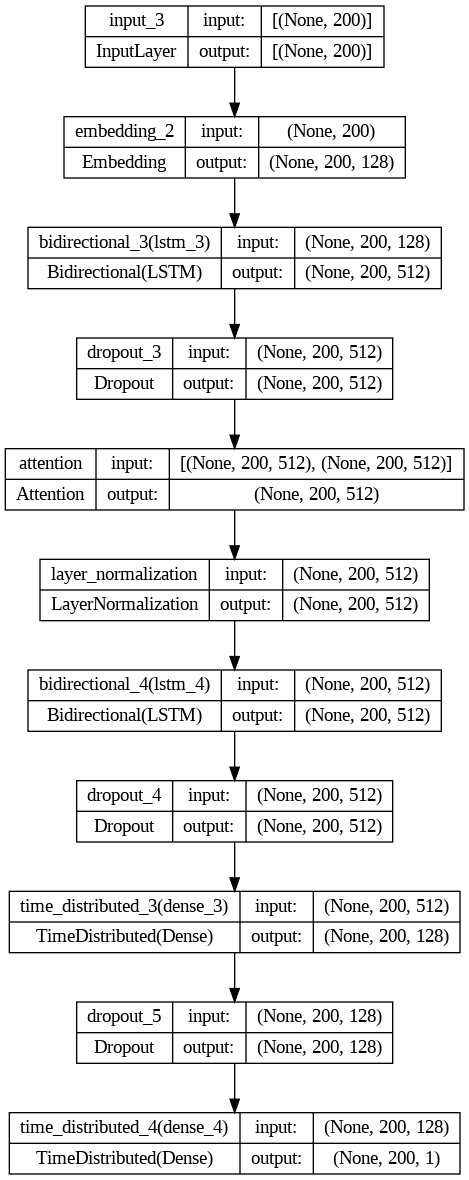

In [ ]:
error_detection = AttentionErrorDetectionModel(
    sentences=dataset, max_length_of_sentence=200, probability_char_swap=0.1, share_train=0.8
)
attention_model = error_detection.attention_model_builder(
    embedding_dim=128, lstm_units=256, dense_neurons=128, dropout_rate=0.2
)
plot_model(attention_model, show_shapes=True)

In [ ]:
error_detection.model_trainer(model=attention_model, epochs=20, batch_size=64, patience=3)
error_detection.save_model_and_tokenizer(filepath_model="detector_attention_model.h5", filepath_tokenizer="detector_attention_tokenizer.json")

Epoch 1/20
1141/1141 [==============================] - 137s 112ms/step - loss: 0.1346 - accuracy: 0.9551 - recall: 0.1962 - val_loss: 0.1093 - val_accuracy: 0.9613 - val_recall: 0.3411
Epoch 2/20
1141/1141 [==============================] - 138s 121ms/step - loss: 0.1047 - accuracy: 0.9631 - recall: 0.3863 - val_loss: 0.0930 - val_accuracy: 0.9671 - val_recall: 0.4375
Epoch 3/20
1141/1141 [==============================] - 137s 120ms/step - loss: 0.0871 - accuracy: 0.9696 - recall: 0.5177 - val_loss: 0.0779 - val_accuracy: 0.9727 - val_recall: 0.5592
Epoch 4/20
1141/1141 [==============================] - 128s 112ms/step - loss: 0.0737 - accuracy: 0.9742 - recall: 0.6051 - val_loss: 0.0677 - val_accuracy: 0.9760 - val_recall: 0.6073
Epoch 5/20
1141/1141 [==============================] - 127s 112ms/step - loss: 0.0657 - accuracy: 0.9770 - recall: 0.6521 - val_loss: 0.0611 - val_accuracy: 0.9781 - val_recall: 0.6336
Epoch 6/20
1141/1141 [==============================] - 127s 112ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


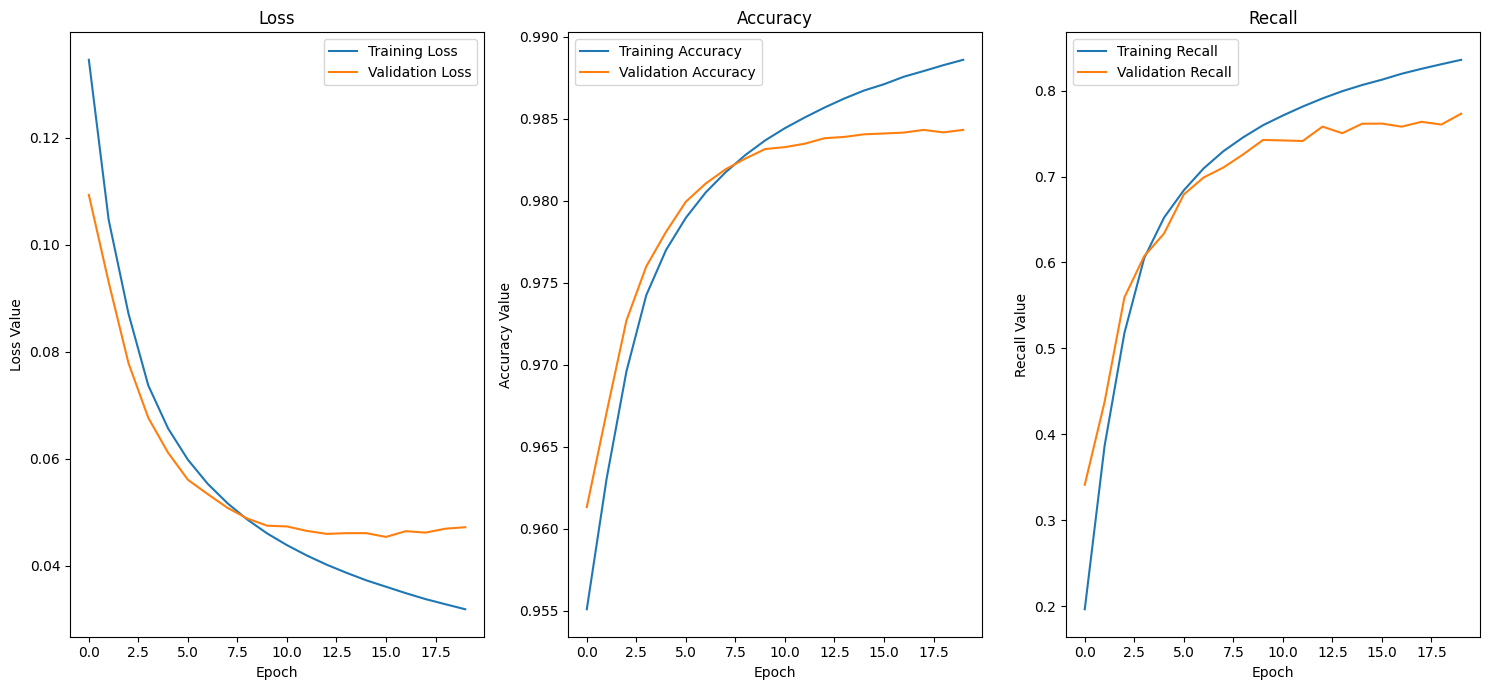

In [ ]:
error_detection.plot_training_metrics(width=15, height = 7)

In [ ]:
error_detection.print_confusion_matrix()

571/571 [==============================] - 15s 24ms/step
Confusion Matrix:
[[3449967   15486]
 [  41722  142225]]

Layout:
[[TN, FP],
 [FN, TP]]

Error Percentages:
False positive rate: 0.45%
False negative rate: 22.68%


In [ ]:
sentence = "tjis is a test senzence with wjich l wanp to test the midel."
_ = error_detection.apply_error_detection_to_a_sentence(sentence, details=True)
sentence = "The hyderparaneters of this model arc not tuted very well."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)
sentence = "He lifes in this verk nice neighburhood."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)

1/1 [==============================] - 0s 30ms/step
t - 0.0
j - 1.0
i - 0.0
s - 0.0
  - 0.0
i - 0.0
s - 0.0
  - 0.0
a - 0.0
  - 0.0
t - 0.04
e - 0.0
s - 0.0
t - 0.0
  - 0.0
s - 0.01
e - 0.01
n - 0.09
z - 1.0
e - 0.0
n - 0.0
c - 0.0
e - 0.0
  - 0.0
w - 0.0
i - 0.0
t - 0.0
h - 0.0
  - 0.0
w - 0.0
j - 1.0
i - 0.0
c - 0.0
h - 0.0
  - 0.0
l - 0.79
  - 0.0
w - 0.03
a - 0.01
n - 0.13
p - 0.37
  - 0.0
t - 0.0
o - 0.0
  - 0.0
t - 0.0
e - 0.0
s - 0.0
t - 0.0
  - 0.0
t - 0.0
h - 0.0
e - 0.0
  - 0.0
m - 0.04
i - 0.08
d - 0.1
e - 0.0
l - 0.04
. - 0.0
Input:  tjis is a test senzence with wjich l wanp to test the midel.
Output: tJis is a test senZence with wJich L wanp to test the midel.
1/1 [==============================] - 0s 32ms/step
Input:  the hyderparaneters of this model arc not tuted very well.
Output: the hyderparaneters of this model arC not tuted very well.
1/1 [==============================] - 0s 26ms/step
Input:  he lifes in this verk nice neighburhood.
Output: he lifes in this verk n

### Load Model and Tokenizer
For this to work the code till after `class ErrorDetectionModel(DatasetPreparation):` has to be run (the part "dataset of correct sentences" can be left out)


In [8]:
error_detection = ErrorDetectionModel()
error_detection.load_model_and_tokenizer(
    filepath_model = "/content/Course_Knowledge_Extraction_and_Information_Retrieval/models_tokenizer/detector_attention_model.h5",
    filepath_tokenizer = "/content/Course_Knowledge_Extraction_and_Information_Retrieval/models_tokenizer/detector_attention_tokenizer.json"
)

In [9]:
sentence = "Here the mudels can be tasted."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)
sentence = "The quelity of the models is at dest mediokre."
_ = error_detection.apply_error_detection_to_a_sentence(sentence,)

1/1 [==============================] - 2s 2s/step
Input:  here the mudels can be tasted.
Output: here the mUdels can be tasted.
1/1 [==============================] - 0s 377ms/step
Input:  the quelity of the models is at dest mediokre.
Output: the quElity of the models is at Dest medioKre.


## 4. Error Correction Model

Model that corrects spelling mistakes. Receives as input also the predictions made by a detection model. A small hyperparamter tuning with a 3-fold cross validation is applied to receive the most optimal performance out of the architecture.




### Train and evaluate the performance of correction model, including hp tuning with cv

In [6]:
class DataAugmentationCorrection(Callback):
    """
    Callback for performing data augmentation at the beginning of each epoch.
    New errors are introduced to the training data.
    """
    def __init__(self, model_instance: Any) -> None:
        super(DataAugmentationCorrection, self).__init__()
        self.model_instance = model_instance


    def on_epoch_begin(self, epoch: int, logs: Optional[Dict[str, Any]] = None) -> None:
        """
        Introduces new errors into the training data at the beginning of each
        epoch, and updates the input matrix
        """

        # Modify erroneous_train
        self.model_instance.erroneous_train = self.model_instance.introduce_random_errors_in_tok_padded_sentences(
            self.model_instance.correct_train
        )
        # Update the error mask
        detection_predictions_train = np.squeeze(
            self.model_instance.model_detection.predict(self.model_instance.erroneous_train)
        )
        self.model_instance.input_train = np.dstack((
            self.model_instance.erroneous_train,
            detection_predictions_train
        ))


In [11]:
class ErrorCorrectionModel(DatasetPreparation):
    def __init__(
        self,
        sentences: Optional[List[str]] = None,
        max_length_of_sentence: int = 200,
        share_train: float = 0.8,
        probability_char_swap: float = 0.1,
        filepath_detector_model: str = "/content/Course_Knowledge_Extraction_and_Information_Retrieval/models_tokenizer/detector_attention_model.h5",
        filepath_detector_tokenizer: str = "/content/Course_Knowledge_Extraction_and_Information_Retrieval/models_tokenizer/detector_attention_tokenizer.json"
    ) -> None:
        super().__init__(
            sentences = sentences,
            max_length_of_sentence = max_length_of_sentence,
            probability_char_swap = probability_char_swap,
            share_train = share_train
        )
        self.load_detection_model_and_tokenizer(
            filepath_model = filepath_detector_model,
            filepath_tokenizer = filepath_detector_tokenizer
            )
        if sentences:
          detection_predictions_train = np.squeeze(self.model_detection.predict(self.erroneous_train))
          self.input_train = np.dstack((self.erroneous_train, detection_predictions_train))
          detection_predictions_test = np.squeeze(self.model_detection.predict(self.erroneous_test))
          self.input_test = np.dstack((self.erroneous_test, detection_predictions_test))


    def load_detection_model_and_tokenizer(self, filepath_model: str, filepath_tokenizer: str) -> None:
        """
        Import attention model and its tokenizer
        """
        self.model_detection = load_model(filepath_model)
        with open(filepath_tokenizer, "rb") as f:
            self.tokenizer = pickle.load(f)
        try:
            self.max_length_of_sentence = self.model_detection.layers[0].input_shape[0][1]
        except TypeError:
            self.max_length_of_sentence = self.model_detection.layers[0].input_shape[1]


    def model_builder(self, dense_units: int, lstm_units: int, dropout_rate: int) -> Sequential:
        """
        Builds the attention model
        """
        vocab_size = len(self.tokenizer.word_index)
        sequence_length = self.max_length_of_sentence
        model_correction = Sequential([
            Input(shape=(sequence_length, 2)),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            Dropout(dropout_rate),
            Bidirectional(LSTM(lstm_units, return_sequences=True)),
            Dropout(dropout_rate),
            TimeDistributed(Dense(dense_units, activation='relu')),
            Dropout(dropout_rate),
            TimeDistributed(Dense(vocab_size, activation='softmax')),
        ])
        model_correction.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model_correction


    def hp_tuning(
        self,
        param_grid: dict,
        max_trials: int,
        cv_splits: int,
        epochs: int,
        patience: int,
        batch_size: int
    ) -> tuple[dict, dict]:
        """
        Performs hyperparameter tuning with cross-validation with the help of random grid search
        """
        all_combinations = list(itertools.product(*param_grid.values()))
        selected_combinations = random.sample(all_combinations, max_trials)

        best_score = 0
        best_params = None
        all_scores = []

        for combination in selected_combinations:
            current_params = dict(zip(param_grid.keys(), combination))
            print(current_params)
            avg_score = 0
            kfold = KFold(n_splits=cv_splits, shuffle=True)
            for train, val in kfold.split(self.input_train, self.correct_train):
                x_train, x_val = self.input_train[train], self.input_train[val]
                y_train, y_val = self.correct_train[train], self.correct_train[val]
                model = self.model_builder(
                    dense_units=current_params['dense_units'],
                    lstm_units=current_params['lstm_units'],
                    dropout_rate=current_params['dropout_rate']
                )
                early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience)
                da_callback = DataAugmentationCorrection(self)
                model.fit(
                    x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, da_callback],
                    verbose=0
                )
                score = model.evaluate(x_val, y_val, verbose=0)[1]
                avg_score += score
            avg_score /= cv_splits
            all_scores.append((current_params, avg_score))
            if avg_score > best_score:
                best_score = avg_score
                best_params = current_params
        return all_scores, best_params


    def model_trainer(
        self,
        model_correction: Sequential,
        epochs: int,
        batch_size: int,
        patience: int
    ):
        """
        Fits the correction model
        """
        # Build the model based on best hyperparameters
        self.model_correction = model_correction
        # Initialize callbacks for data augmentation and early stopping
        da_callback = DataAugmentationCorrection(self)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience)
        # Train the model
        self.history = self.model_correction.fit(
                self.input_train, self.correct_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(self.input_test, self.correct_test),
                callbacks=[early_stopping, da_callback]
        )
        # Evaluate the model on test data and print metrics
        loss, accuracy = self.model_correction.evaluate(self.input_test, self.correct_test)
        print(f"\nLoss on the test set: {loss:.4f}")
        print(f"Accuracy on the test set: {accuracy:.4f}")


    def plot_training_metrics(self, width: float, height: float) -> None:
        """
        Plot the development of loss and accuracy over the training process.
        """
        plt.figure(figsize=(width, height))
        metrics = ["loss", "accuracy"]

        for idx, metric in enumerate(metrics, 1):
            plt.subplot(1, 2, idx)
            plt.plot(self.history.history[metric], label=f"Training {metric.capitalize()}")
            plt.plot(self.history.history[f"val_{metric}"], label=f"Validation {metric.capitalize()}")
            plt.title(metric.capitalize())
            plt.xlabel("Epoch")
            plt.ylabel(f"{metric.capitalize()} Value")
            plt.legend()

        plt.tight_layout()
        plt.show()


    def correct_errors_in_sentence(self, erroneous_sentence: str, details=False):
        """
        Applies the correction model on a given sentence.
        """
        erroneous_sentence = self.format_a_sentence(erroneous_sentence, raise_error=True)
        sentence_tok_and_padded = self.tokenize_and_pad_list_of_sentences(sentences=[erroneous_sentence])
        # Make error prediction
        errors = self.model_detection.predict(sentence_tok_and_padded)
        errors = np.squeeze(errors)
        # Retrieve detected errors
        error_detect_sentence = ''.join(
            self.tokenizer.index_word[i].upper() if flag>=0.5 else self.tokenizer.index_word[i].lower()
            for i, flag in zip(sentence_tok_and_padded[0], list(errors)) if i != 0
            )
        # input
        input = np.dstack((sentence_tok_and_padded, errors))
        # predict
        predictions = self.model_correction.predict(input)
        if not details:
            predicted_char = [self.tokenizer.index_word[token] for token in np.argmax(predictions, axis=-1)[0] if token != 0]
            output = "".join(predicted_char)

            print(f"input:              {erroneous_sentence}")
            print(f"detected errors:    {error_detect_sentence}")
            print(f"corrected sentence: {output}")

        else:
            rows = []
            for i, probs in zip(sentence_tok_and_padded[0], predictions[0]):
                if i != 0:
                    top_indices = np.argsort(probs)[-3:][::-1]
                    top_tokens = [self.tokenizer.index_word[idx] for idx in top_indices]
                    top_probs = [probs[idx] for idx in top_indices]

                    row_data = {'Original_Token': self.tokenizer.index_word[i]}

                    for rank, (token, prob) in enumerate(zip(top_tokens, top_probs), 1):
                        if rank == 1 or (rank > 1 and top_probs[0] < 0.9):
                            row_data[f'{rank}_Predicted_Token'] = token
                            row_data[f'{rank}_Probability'] = round(prob, 2)
                        else:
                            break

                    rows.append(row_data)

            display(pd.DataFrame(rows))


    def save_correction_model(self, filepath_model: str = "correction_model.h5"):
        """
        Save the correction model
        """
        self.model_correction.save(filepath_model)
        print("\nModel successfully saved")


    def load_correction_model(self, filepath_model: str):
        """
        Load the correction model
        """
        self.model_correction = load_model(filepath_model)


In [ ]:
correction_model = ErrorCorrectionModel(
    sentences=dataset, max_length_of_sentence=200, probability_char_swap=0.1, share_train=0.8
)

Number of sentences after formating: 91373
Training set: 73098
Test set: 18275
572/572 [==============================] - 13s 22ms/step


In [ ]:
param_grid = {
    'dense_units': [64, 128, 256],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.15]
}
all_scores, best_params = correction_model.hp_tuning(
    param_grid=param_grid, max_trials=2, cv_splits=3, epochs=10, patience=2, batch_size=64
)
print(all_scores)

In [ ]:
param_grid = {
    'dense_units': [64, 128, 256],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.1, 0.15]
}
all_scores, best_params = correction_model.hp_tuning(
    param_grid=param_grid, max_trials=2, cv_splits=3, epochs=10, patience=2, batch_size=64
)
print(all_scores)

{'dense_units': 64, 'lstm_units': 64, 'dropout_rate': 0.1}
2285/2285 [==============================] - 54s 24ms/step
{'dense_units': 64, 'lstm_units': 256, 'dropout_rate': 0.15}
2285/2285 [==============================] - 51s 23ms/step
[({'dense_units': 64, 'lstm_units': 64, 'dropout_rate': 0.1}, 0.9655308127403259), ({'dense_units': 64, 'lstm_units': 256, 'dropout_rate': 0.15}, 0.9698300361633301)]


In [ ]:
best_params = {"dense_units": 64, "lstm_units":256, "dropout_rate": 0.15}

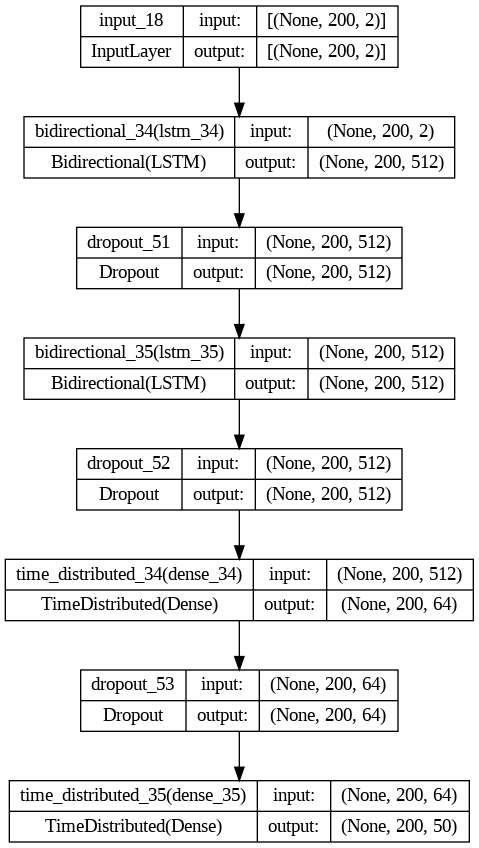

In [ ]:
best_correction_model = correction_model.model_builder(
    dense_units=best_params["dense_units"],
    lstm_units=best_params["lstm_units"],
    dropout_rate=best_params["dropout_rate"],
)

plot_model(best_correction_model, show_shapes=True)

In [ ]:
correction_model.model_trainer(
    model_correction=best_correction_model,
    batch_size=64,
    epochs=20,
    patience=3,
)

2285/2285 [==============================] - 51s 22ms/step
Epoch 1/20
2285/2285 [==============================] - 51s 22ms/step
Epoch 2/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 3/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 4/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 5/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 6/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 7/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 8/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 9/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 10/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 11/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 12/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 13/20
2285/2285 [==============================] - 52s 23ms/step
Epoch 14/20
2285/2285 [====

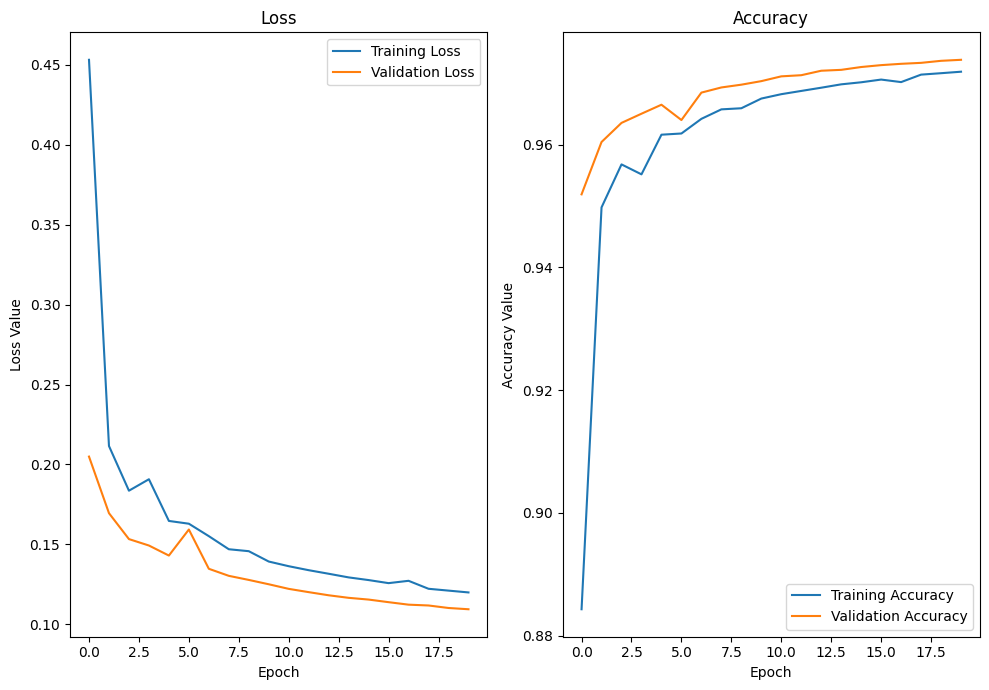

In [ ]:
correction_model.plot_training_metrics(width=10, height=7)

In [ ]:
correction_model.save_correction_model()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model successfully saved


In [ ]:
sentence = "tjis is a test senzence with wjich l wanp to test the midel."
_ = correction_model.correct_errors_in_sentence(sentence)
sentence = "The hyderparaneters of this model arc not tuted very well."
_ = correction_model.correct_errors_in_sentence(sentence,)
sentence = "He lifes in this verk nice neighburhood."
_ = correction_model.correct_errors_in_sentence(sentence,)

1/1 [==============================] - 2s 2s/step
input:              tjis is a test senzence with wjich l wanp to test the midel.
detected errors:    tJis is a test senZence with wJich L wanp to test the midel.
corrected sentence: this is a test sentence with wjich a wand to test the midel.
1/1 [==============================] - 0s 27ms/step
input:              the hyderparaneters of this model arc not tuted very well.
detected errors:    the hyderparaneters of this model arC not tuted very well.
corrected sentence: the hyderparaneters of this model are not tuted very well.
1/1 [==============================] - 0s 25ms/step
input:              he lifes in this verk nice neighburhood.
detected errors:    he lifes in this verk nice neighbUrhood.
corrected sentence: he lifes in this verk nice neighbarhood.


In [ ]:
sentence = "tjis is a test senzence with wjich l wanp to test the midel."
_ = correction_model.correct_errors_in_sentence(sentence, details=True)


1/1 [==============================] - 0s 76ms/step


,Original_Token,1_Predicted_Token,1_Probability,2_Predicted_Token,2_Probability,3_Predicted_Token,3_Probability
0,t,t,1.00,NaN,NaN,NaN,NaN
1,j,h,0.97,NaN,NaN,NaN,NaN
2,i,i,1.00,NaN,NaN,NaN,NaN
3,s,s,1.00,NaN,NaN,NaN,NaN
4,,,1.00,NaN,NaN,NaN,NaN
5,i,i,1.00,NaN,NaN,NaN,NaN
6,s,s,1.00,NaN,NaN,NaN,NaN
7,,,1.00,NaN,NaN,NaN,NaN
8,a,a,1.00,NaN,NaN,NaN,NaN
9,,,1.00,NaN,NaN,NaN,NaN


### Load correction model to test

In [12]:
error_correction = ErrorCorrectionModel()
error_correction.load_correction_model(
    filepath_model = "/content/Course_Knowledge_Extraction_and_Information_Retrieval/models_tokenizer/correction_model.h5",
)

In [13]:
sentence = "Here the mudels can be tasted."
_ = error_correction.correct_errors_in_sentence(sentence,)
sentence = "The quelity of the models is at dest mediokre."
_ = error_correction.correct_errors_in_sentence(sentence,)

1/1 [==============================] - 2s 2s/step
input:              here the mudels can be tasted.
detected errors:    here the mUdels can be tasted.
corrected sentence: here the mudels can be tasted.
1/1 [==============================] - 0s 164ms/step
input:              the quelity of the models is at dest mediokre.
detected errors:    the quElity of the models is at Dest medioKre.
corrected sentence: the quality of the models is at dest medioure.
